In [3]:
#Verify if GPU is connected
import tensorflow as tf

print("TensorFlow version: ", tf.__version__)

if tf.test.gpu_device_name():
   print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

TensorFlow version:  2.6.0
Default GPU Device: /device:GPU:0


In [4]:
# Use this to check path
# import OS module
import os
# Get the list of all files and directories
path = "../data"
dir_list = os.listdir(path)
print("Files and directories in '", path, "' :")
# prints all files
print(dir_list)

#Test if a file exsist (Omar method)
!du -sh "/content/content/flat_split"

Files and directories in ' ../data ' :
['content', 'dataset-v3.csv']


'du' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import json
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv("../data/dataset-v3.csv")

# Define the image directory
image_dir = '../data/content/content/flat_split/'  # Change this to the directory where images are extracted

# Parse the 'choice' column to extract labels
def parse_choices(choice_str):
    if pd.isna(choice_str) or not choice_str.strip():
        return []
    try:
        choices = json.loads(choice_str.replace("'", "\""))['choices']
        label_map = {"Clover": 0, "Grass": 1, "Dung": 2, "Sheep Dung": 3, "Soil": 4, "Artifact": 5}
        label = [label_map[choice] for choice in choices if choice in label_map]
        return label
    except (json.JSONDecodeError, KeyError, TypeError):
        return None

df['labels'] = df['choice'].apply(parse_choices)

# Filter out rows with parsing errors (None) but keep rows with empty lists
df = df[df['labels'].notna()]

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create a function to map the image path
def get_full_path(img_name):
    return os.path.join(image_dir, img_name.split('/')[-1].replace("%20", " "))

# Apply the function to get full paths
train_df['image'] = train_df['image'].apply(get_full_path)
val_df['image'] = val_df['image'].apply(get_full_path)

In [6]:
print(train_df)
train_df.to_csv('train.csv')

       annotation_id  annotator                                     choice  \
8794           12453          5             {"choices":["Clover","Grass"]}   
11439           7435         10               {"choices":["Grass","Dung"]}   
2016           13283          5               {"choices":["Grass","Dung"]}   
3913           11079         11             {"choices":["Clover","Grass"]}   
6797           12497          5             {"choices":["Clover","Grass"]}   
...              ...        ...                                        ...   
14017           1522          3           {"choices":["Grass","Artifact"]}   
1426            9230         10               {"choices":["Grass","Dung"]}   
9759           12865          5             {"choices":["Clover","Grass"]}   
11931          14715          5  {"choices":["Grass","Sheep Dung","Soil"]}   
2708            3365          9             {"choices":["Clover","Grass"]}   

                        created_at      id  \
8794   2024-07-17

In [7]:
class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, target_size=(384, 384), shuffle=True, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[indexes]

        images = []
        labels = []
        for _, row in batch_df.iterrows():
            img_path = row['image']
            image = tf.keras.preprocessing.image.load_img(img_path, target_size=self.target_size)
            image = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalize image

            label = np.zeros(6)  # 6 classes
            for l in row['labels']:
                label[l] = 1

            images.append(image)
            labels.append(label)

        return np.array(images), np.array(labels)

# Create the data generators
train_generator = MultiLabelDataGenerator(train_df, augment=True)
val_generator = MultiLabelDataGenerator(val_df, augment=False)


In [8]:
def create_model():
    model = tf.keras.models.Sequential()

    # 1st Convolution block
    model.add(tf.keras.layers.Conv2D(32, (11, 11), activation='relu', input_shape=(384, 384, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  # Downsampling to 192x192x32

    # 2nd Convolution block
    model.add(tf.keras.layers.Conv2D(64, (7, 7), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  # Downsampling to 96x96x64

    # 3rd Convolution block (repeated twice)
    model.add(tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # 5th Convolution block
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(tf.keras.layers.MaxPooling2D((4, 4)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Final Convolution block
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  # Downsampling to 6x6x256

    model.add(tf.keras.layers.Flatten())  # Flatten to 9216x1

    # Fully connected layers
    model.add(tf.keras.layers.Dense(6400, activation='relu'))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dense(1000, activation='relu'))
    model.add(tf.keras.layers.Dense(6, activation='sigmoid'))  # 6 output classes for multi-label

    return model

model = create_model()

model.compile(optimizer= Adam(learning_rate=1e-5),
              loss='binary_crossentropy',  # Use binary cross-entropy for multi-label classification
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 128)       0

In [9]:
import matplotlib.pyplot as plt
import pickle

def run_exp(lr, lr_nice):
    print(f'Experiment LR = {lr_nice}')
    #Creat the model
    model = create_model()

    model.compile(optimizer= Adam(learning_rate=lr),
              loss='binary_crossentropy',  # Use binary cross-entropy for multi-label classification
              metrics=['accuracy'])

    model.summary()
    
    # Train the model in iterations
    iterations = 30
    epochs_per_iteration = 10

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for i in range(iterations):

        print(f"Iteration {i+1}/{iterations}")

        hist = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            validation_data=val_generator,
            validation_steps=len(val_generator),
            epochs=(i+1)*epochs_per_iteration, #original is just epochs_per_iteration
            initial_epoch=i*epochs_per_iteration
        )

        # Save the model after each iteration
        model.save(f'lr{lr_nice}_paper_cnn_model_iteration_{i+1}.h5')

        # Append metrics to history
        history['loss'].extend(hist.history['loss'])
        history['val_loss'].extend(hist.history['val_loss'])
        history['accuracy'].extend(hist.history['accuracy'])
        history['val_accuracy'].extend(hist.history['val_accuracy'])
    
    # Final evaluation
    loss, accuracy = model.evaluate(val_generator)
    print(f'Validation Loss: {loss}')
    print(f'Validation Accuracy: {accuracy}')

    # Plotting the metrics
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    import pickle

    with open(f'lr{lr_nice}_hist.pkl', 'wb') as f:
        pickle.dump(history, f)

Experiment LR = 1e-5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (Non

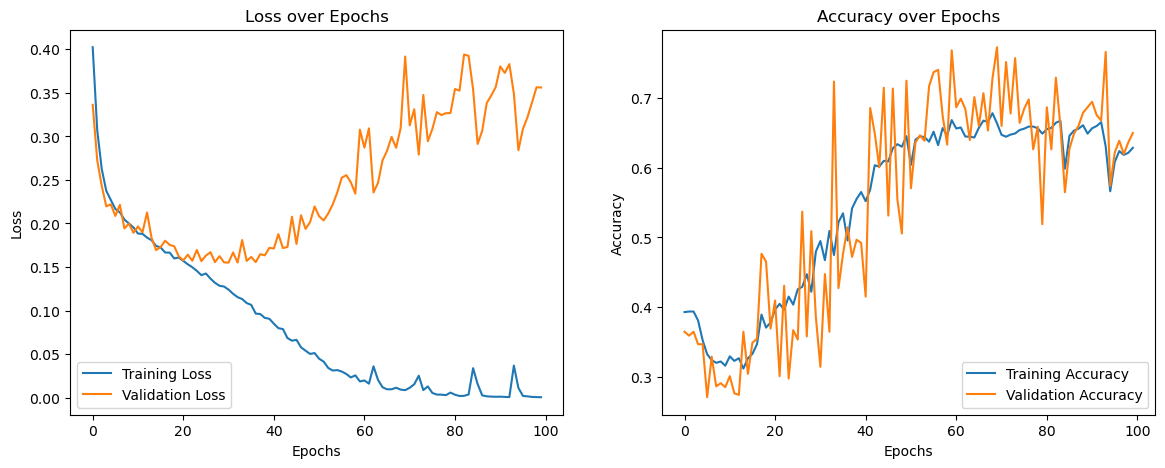

Experiment LR = 1e-6
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (Non

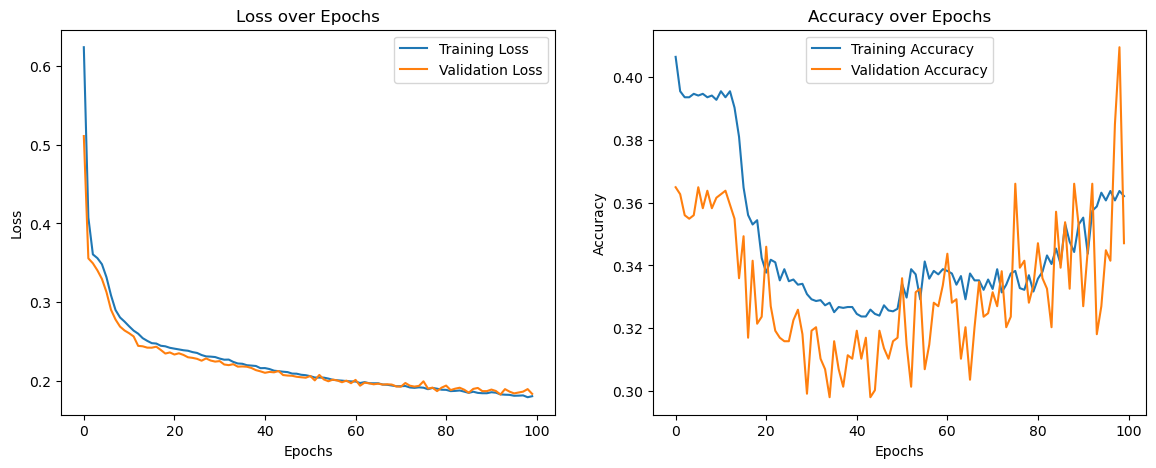

Experiment LR = 1e-4
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (Non

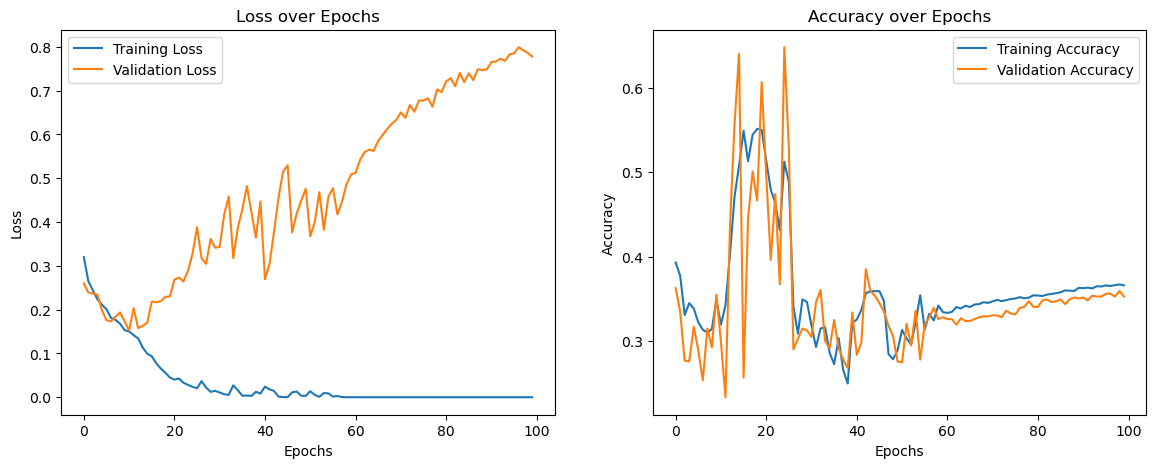

Experiment LR = 1e-3
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (Non

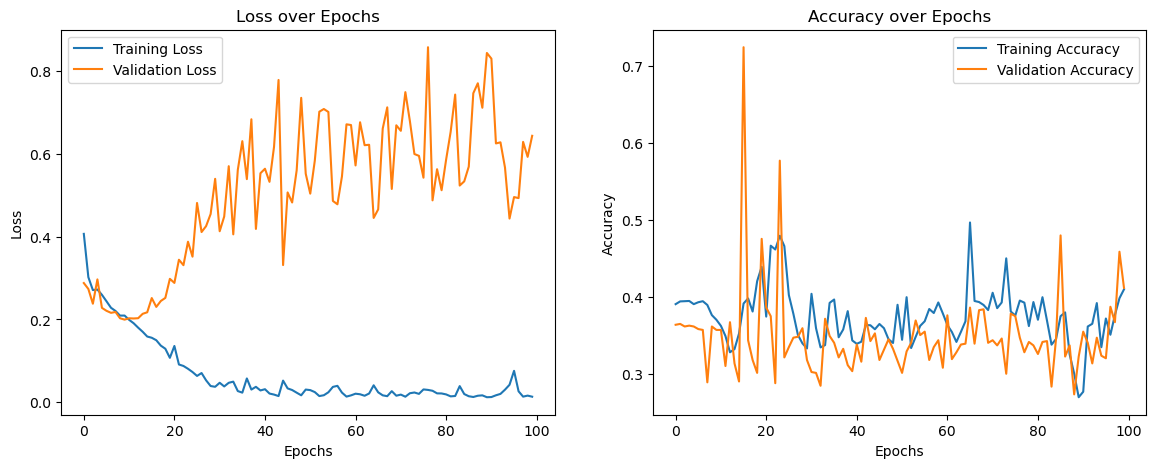

Experiment LR = 1e-2
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (Non

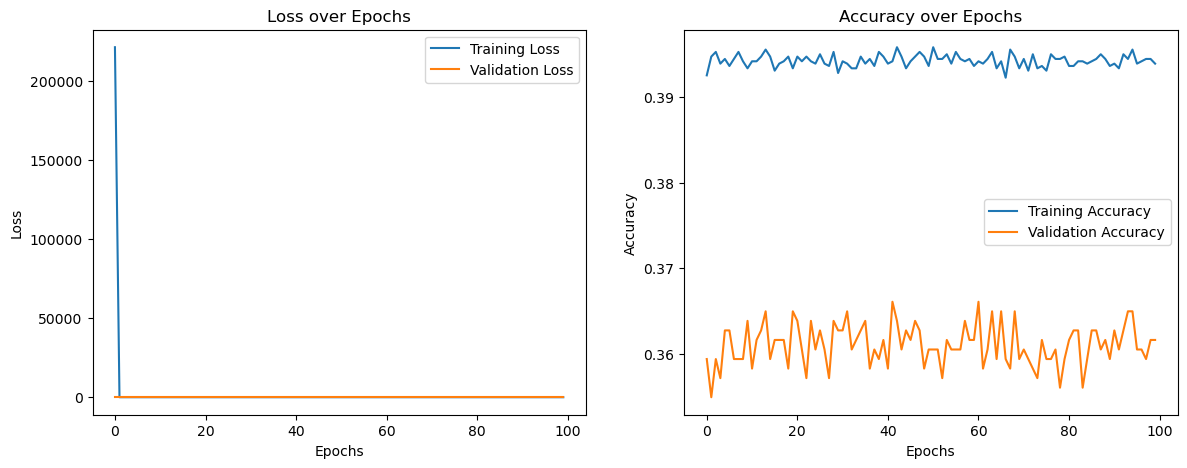

Experiment LR = 1e-7
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_38 (MaxPooling (Non

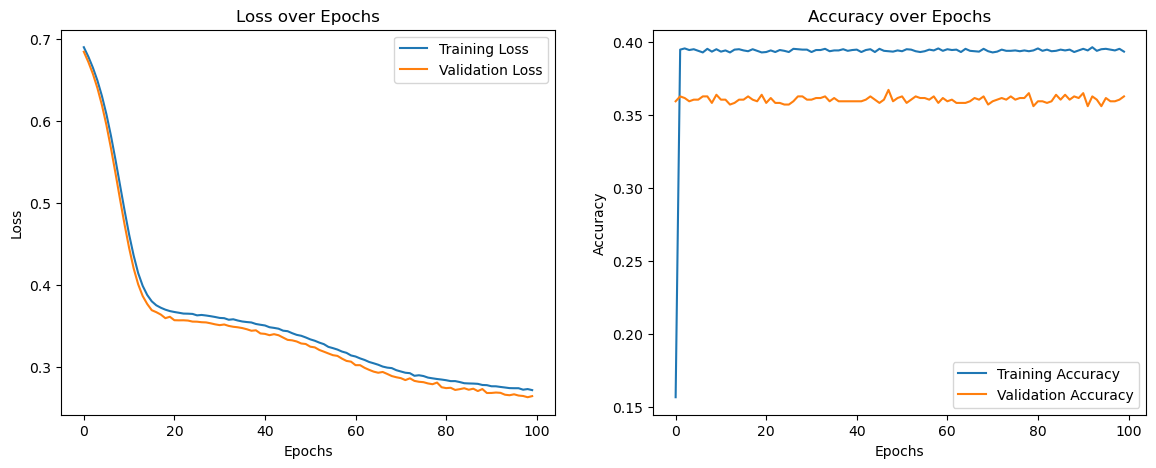

In [8]:
run_exp(1e-5, '1e-5')
run_exp(1e-6, '1e-6')
run_exp(1e-4, '1e-4')
run_exp(1e-3, '1e-3')
run_exp(1e-2, '1e-2')
run_exp(1e-7, '1e-7')

1e-5 and 1e-6 are the best learning rate with 10 iteration each with 10 epchs.
Now try 1e-5 1.25e-5 1.5e-5 1.75e-5 1e-6 with 30 iteration each with 10 epochs.

Experiment LR = 1e-5
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_68 (MaxPooling (No

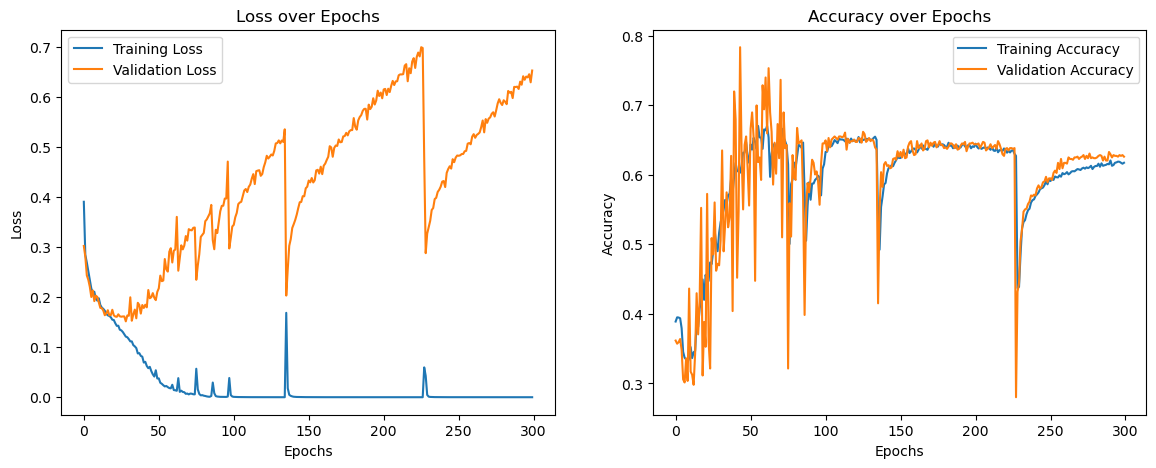

Experiment LR = 1.25e-5
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_74 (MaxPooling 

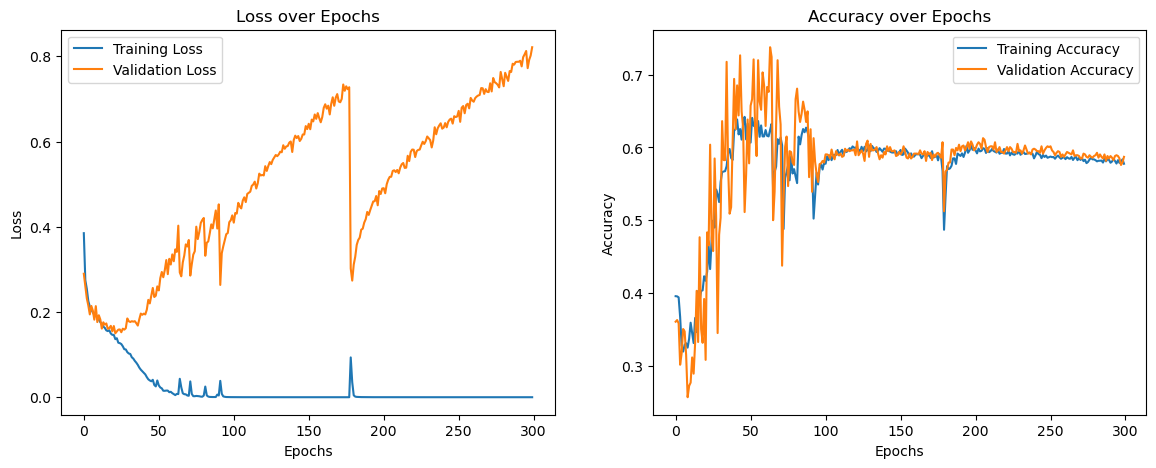

Experiment LR = 1.5e-5
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_80 (MaxPooling (

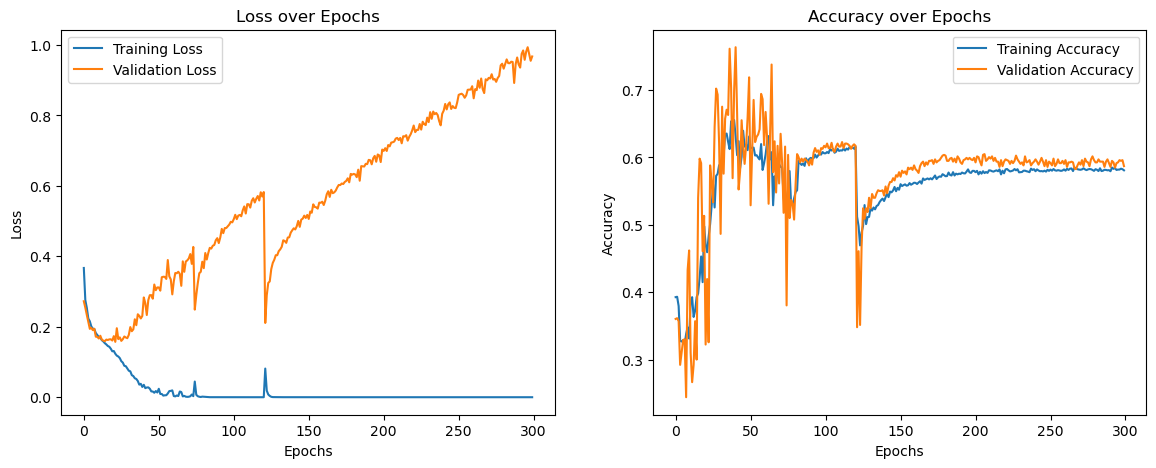

Experiment LR = 1.75e-5
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_86 (MaxPooling 

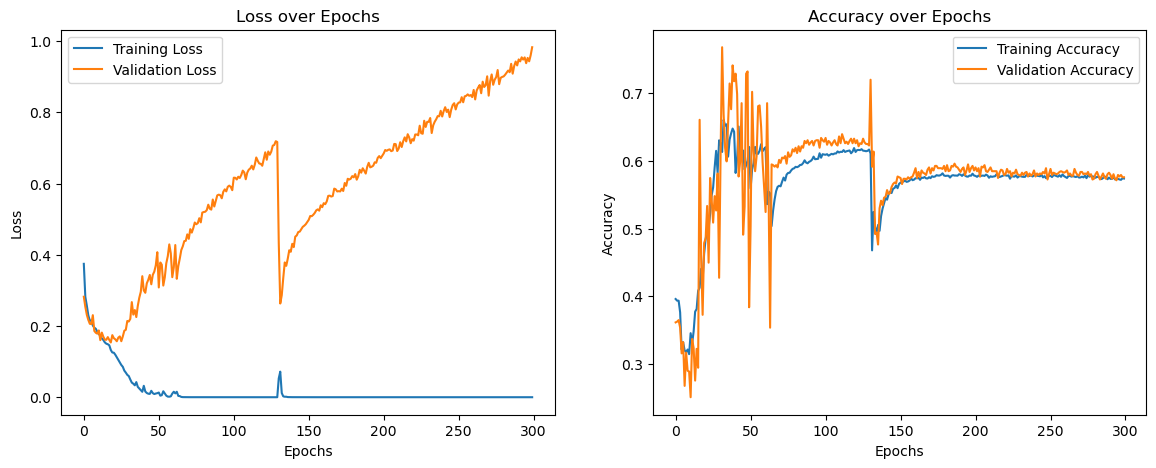

Experiment LR = 1e-6
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_92 (MaxPooling (No

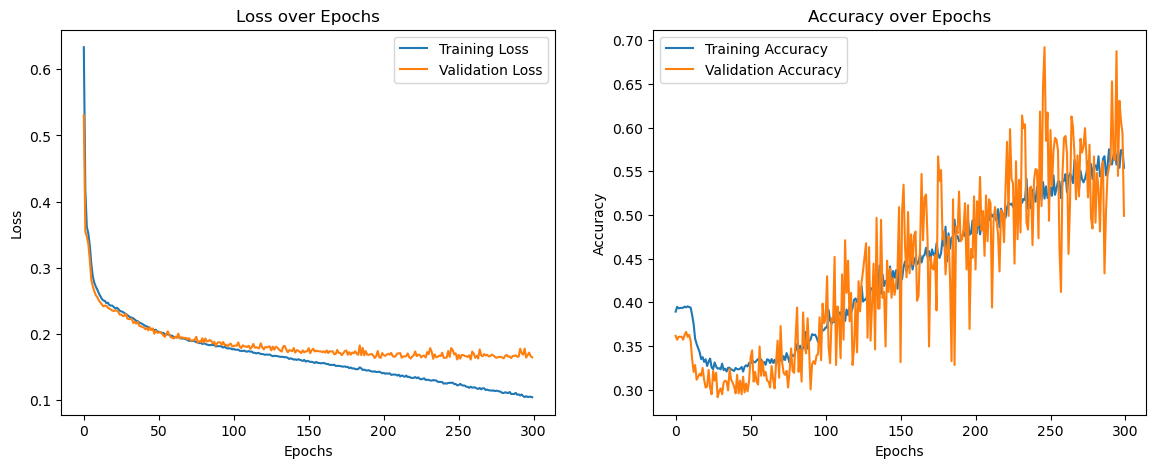

In [21]:
run_exp(1e-5, '1e-5')
run_exp(1.25e-5, '1.25e-5')
run_exp(1.5e-5, '1.5e-5')
run_exp(1.75e-5, '1.75e-5')
run_exp(1e-6, '1e-6')

Experiment LR = 0.75e-5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (

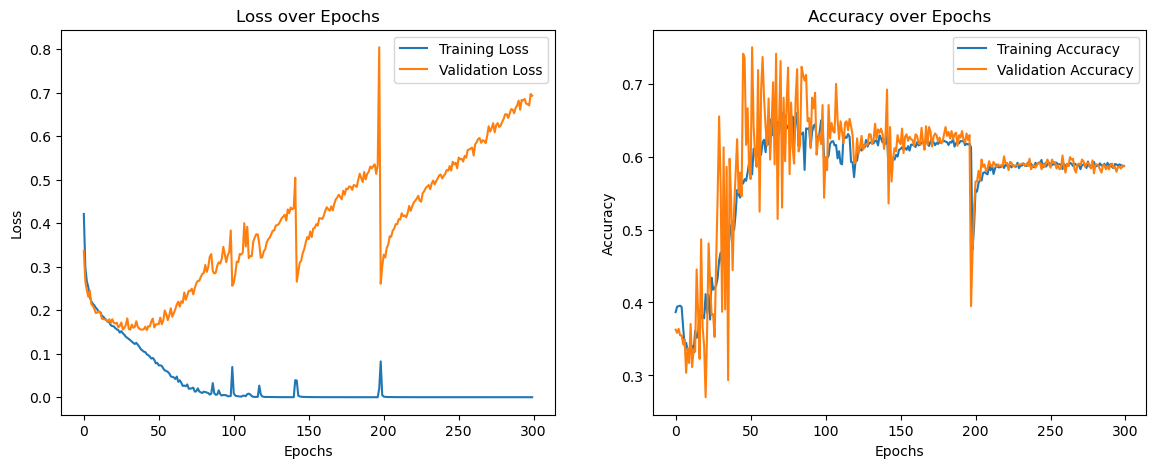

Experiment LR = 0.5e-5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 374, 374, 32)      11648     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 181, 181, 64)      100416    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 90, 90, 128)       204928    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 90, 90, 128)       409728    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (N

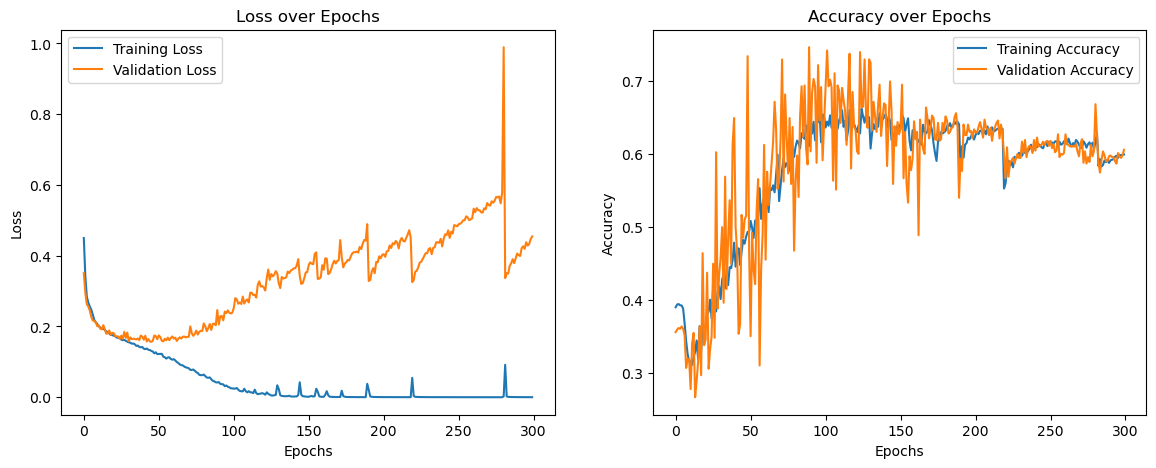

In [10]:
run_exp(0.75e-5, '0.75e-5')
run_exp(0.5e-5, '0.5e-5')